In [1]:
import numpy as np
from tqdm import tqdm
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation, RecordEpisodeStatistics
import torch
from matplotlib import pyplot as plt
import matplotlib

from clinic_environment import ClinicEnv
from clinic_agent import ClinicDQNAgent, ReplayMemory, Transition

In [2]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [3]:
learning_rate = 1e-4
n_episodes = 5_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

In [4]:
clinic_capacity = np.array([1, 2])
clinic_travel_times = np.array([[0, 10], [10, 0]])
patient_times = np.array([30, 40])
num_nurses = 2

unwrapped_clinic_env = ClinicEnv(clinic_capacity, clinic_travel_times, patient_times, num_nurses)
clinic_env = RecordEpisodeStatistics(FlattenObservation(unwrapped_clinic_env))
clinic_env.get_valid_actions = unwrapped_clinic_env.get_valid_actions

In [5]:
agent = ClinicDQNAgent(
    clinic_env, 
    learning_rate=learning_rate, 
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    device="cuda",
)

In [6]:
def plot_reward(reward_per_episode, show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(reward_per_episode, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
            

In [17]:
def play_episode(env, agent, randomize: bool = False):
    obs, info = env.reset()
    done = False

    total_reward = 0
    while not done:
        action = agent.get_action(obs, randomize=randomize)
        next_obs, reward, terminated, truncated, info = env.step(action.item())

        agent.update(obs, action, reward, terminated, next_obs)

        done = terminated or truncated
        obs = next_obs
        total_reward += reward

    return total_reward

In [8]:
reward_per_episode = []
while len(agent.memory) <= 5_000:
    play_episode(clinic_env, agent)
    
for episode in range(n_episodes):
    total_reward = play_episode(clinic_env, agent)
    reward_per_episode.append(total_reward) 
    plot_reward(agent.training_error)

    agent.decay_epsilon()

<Figure size 640x480 with 0 Axes>

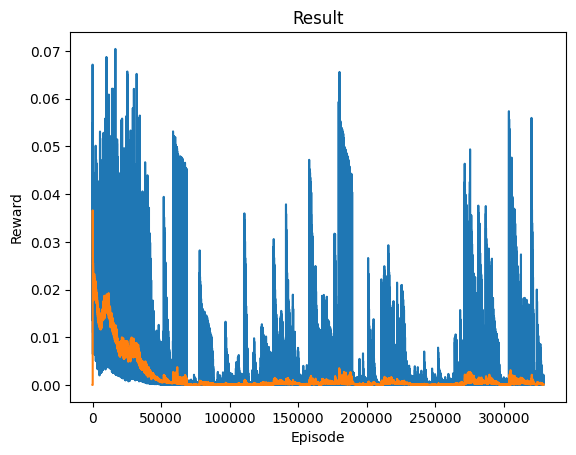

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
plot_reward(agent.training_error, show_result=True)

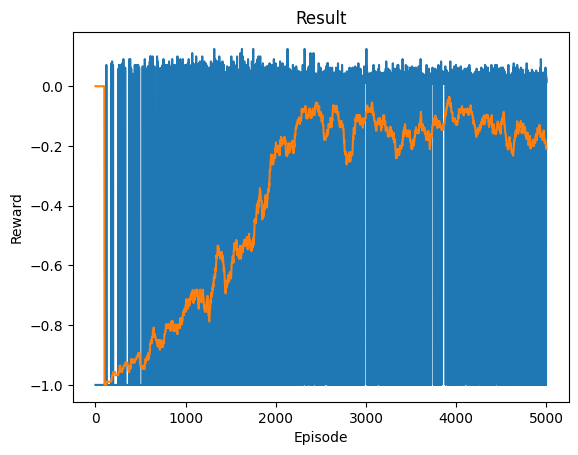

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
plot_reward(reward_per_episode, show_result=True)

In [27]:
play_episode(clinic_env, agent, randomize=True)

0.029411764705882353